# UK University Research Excellence Framework Ratings 2014



## Set up

### Install SQLite

In [ ]:
!pip install -q pysqlite3-binary

     |████████████████████████████████| 5.2MB 21.9MB/s 


### Define functions

In [ ]:
# #@title Define functions
import tempfile
from urllib import request
import sqlite3
import pysqlite3

from typing import Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

#%load_ext google.colab.data_table

# Set float display options for pandas dataframes.
pd.options.display.float_format = "{:,.2f}".format

def excel_dataset_to_sqlite(url: str, database_name: str = ":memory:") -> sqlite3.Connection:
  """Downloads an excel dataset and loads it into an sqlite database."""

  # Download the data into a local variable.
  data = request.urlopen(url).read()

  # Write it out to afiles
  with tempfile.TemporaryFile() as fle:
    fle.write(data)

    # Read into pandas from excel file.
    data = pd.read_excel(fle, sheet_name=None)

  # Create a database.
  conn = pysqlite3.connect(database_name)

  # Loads data from pandas objects into individual tables.
  for (key, sheet) in data.items():
    sheet = sheet.where(pd.notnull(sheet), None)
    sheet.to_sql(key, conn)


  # Return database.
  return conn

## Prepare the data

### Import the dataset and create the database

In [ ]:
database = excel_dataset_to_sqlite("https://public.tableau.com/s/sites/default/files/media/Resources/Research%20Excellence%20Framework%202014%20Results_Pivoted.xlsx")

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


### View the table names to make sure the correct tables have been created

In [ ]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", database)

,name
0,Sheet1-Tableau
1,About


### That table name isn't very helpful. Let's change it to something more meaningful.

In [ ]:
pd.read_sql("ALTER TABLE 'Sheet1-Tableau' RENAME TO REF_Results;", database)

,1


In [ ]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", database)

,name
0,REF_Results
1,About


### Now let's have a look at the column names to make sure they won't make it difficult to work with this dataset.

In [ ]:
pd.read_sql("SELECT * FROM REF_Results;", database)

,index,Institution code (UKPRN),Institution name,Institution sort order,Main panel,Unit of assessment number,Unit of assessment name,Multiple submission letter,Multiple submission name,Joint submission,Profile,FTE Category A staff submitted,Star Rating,Percentage
0,0,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,4*,6.4
1,1,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,3*,68.1
2,2,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,2*,25.5
3,3,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,1*,0
4,4,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,unclassified,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38215,38215,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,4*,21
38216,38216,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,3*,39
38217,38217,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,2*,22
38218,38218,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,1*,12


### Those column names are going to make working with this table painful. Let's change them to make life easier for ourselves.

In [ ]:
pd.read_sql("""Alter Table REF_Results
             Rename Column `Institution Code (UKPRN)` To Institution_Code;""", database)

pd.read_sql("""Alter Table REF_Results
             Rename Column `Institution Name` To Institution_Name;""", database)

pd.read_sql("""Alter Table REF_Results
             Rename Column `Institution Sort Order` To Institution_Sort_Order;""", database)

pd.read_sql("""Alter Table REF_Results
             Rename Column `Main Panel` To Main_Panel;""", database)

pd.read_sql("""Alter Table REF_Results
             Rename Column `Unit of Assessment Number` To Unit_of_Assessment_Number;""", database)

pd.read_sql("""Alter Table REF_Results
             Rename Column `Unit of Assessment Name` To Unit_of_Assessment_Name;""", database)

pd.read_sql("""Alter Table REF_Results
             Rename Column `FTE Category A staff submitted` To FTE_Category_A_staff_submitted;""", database)

pd.read_sql("""Alter Table REF_Results
             Rename Column `Star Rating` To Star_Rating;""", database)

pd.read_sql("SELECT * FROM REF_Results;", database)


,index,Institution_Code,Institution_Name,Institution_Sort_Order,Main_Panel,Unit_of_Assessment_Number,Unit_of_Assessment_Name,Multiple submission letter,Multiple submission name,Joint submission,Profile,FTE_Category_A_staff_submitted,Star_Rating,Percentage
0,0,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,4*,6.4
1,1,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,3*,68.1
2,2,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,2*,25.5
3,3,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,1*,0
4,4,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,unclassified,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38215,38215,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,4*,21
38216,38216,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,3*,39
38217,38217,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,2*,22
38218,38218,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,1*,12


## Understand the data

The dataset has 38,220 rows. But how many unique records do we have in each of the 14 columns?

We can see that 154 institutions are included in the dataset, and that they were assessed in 36 different subjects.

In [ ]:
pd.read_sql("""SELECT COUNT(DISTINCT Institution_Name) AS Institutions,
                COUNT(DISTINCT Institution_Sort_Order) AS Institution_Sort_Order,
                COUNT(DISTINCT Unit_of_Assessment_Name) AS Units_of_Assessment
                FROM REF_Results;""", database)


,Institutions,Institution_Sort_Order,Units_of_Assessment
0,154,154,36


## Analyze the data

### Let's start by seeing which universities were assessed across the widest range of subjects.

We know there are 36 unique subjects in the database. It seems that no single institution was assessed on all of them - UCL has the widest range at 32 of the 36 subjects - and some universities were only assessed in one subject.

In [ ]:
result = pd.read_sql("""SELECT Institution_Name, COUNT(DISTINCT Unit_of_Assessment_Name)
                FROM REF_Results
                GROUP BY Institution_Name
                ORDER BY COUNT(DISTINCT Unit_of_Assessment_Name) DESC
                LIMIT 20;""", database)

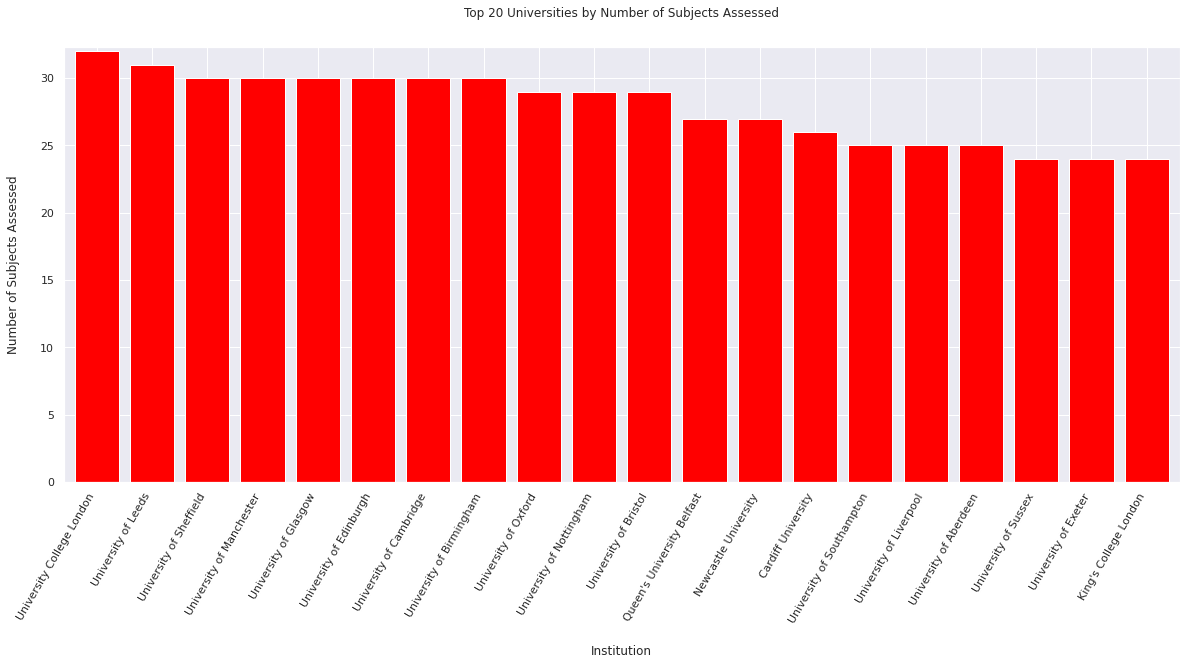

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Institution_Name"], height=result["COUNT(DISTINCT Unit_of_Assessment_Name)"], color='red')
plt.title("Top 20 Universities by Number of Subjects Assessed", pad = 30)
plt.xlabel("Institution", labelpad=20)
plt.ylabel("Number of Subjects Assessed", labelpad=20)
_ = plt.xticks(rotation = 60, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

We can look at the distribution of universities based on the number of subjects they were assessed on. It seems that most universities were assessed on only a small number of subjects, with 26 universities having been evaluated in only one subject. No university was evaluated on all 36 possible subject areas.

In [ ]:
result = pd.read_sql("""WITH Institutions_By_Assessment_Count AS 
                            (SELECT Institution_Name, 
                             COUNT(DISTINCT Unit_of_Assessment_Name) AS Number_of_Assessment_Units
                             FROM REF_Results GROUP BY Institution_Name)
                
                SELECT DISTINCT Number_of_Assessment_Units,
                COUNT(DISTINCT Institution_Name) AS Number_of_Institutions,
                SUM(COUNT(DISTINCT Institution_Name)) OVER (
                    ORDER BY Number_of_Assessment_Units
                    ROWS BETWEEN UNBOUNDED PRECEDING
                    AND CURRENT ROW
                    ) AS Running_Total
                FROM Institutions_By_Assessment_Count
                GROUP BY Number_of_Assessment_Units
                ORDER BY Number_of_Assessment_Units ASC;""", database)

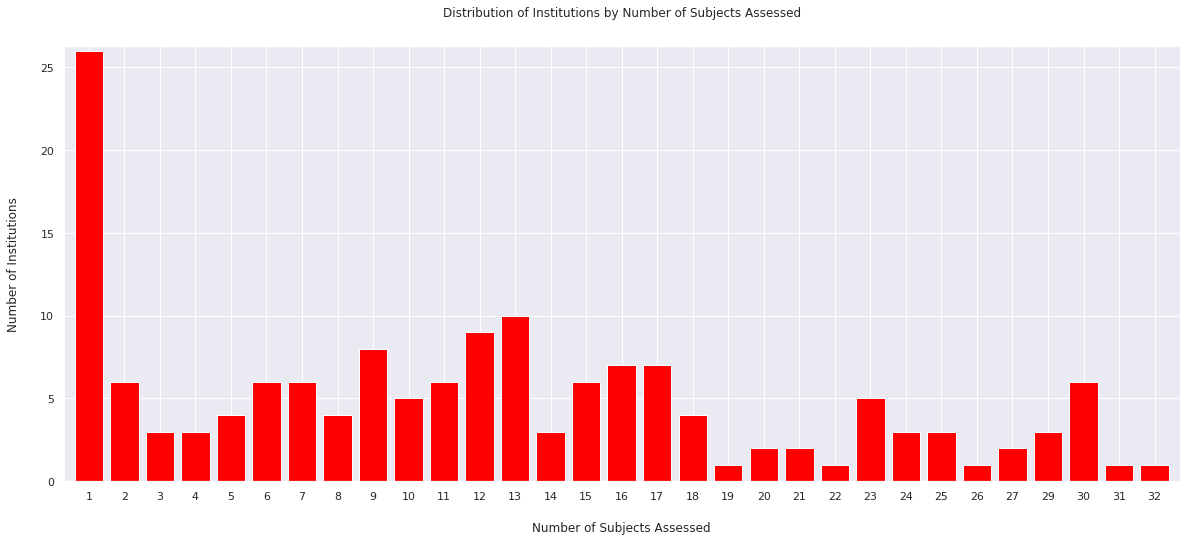

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Number_of_Assessment_Units"].astype(str), height=result["Number_of_Institutions"], color='red')
plt.title("Distribution of Institutions by Number of Subjects Assessed", pad = 30)
plt.xlabel("Number of Subjects Assessed", labelpad=20)
plt.ylabel("Number of Institutions", labelpad=20)
_ = plt.xticks(rotation = 0, ha = "center")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

### And which subjects are the most common among the universities assessed?

In [ ]:
result = pd.read_sql("""SELECT Unit_of_Assessment_Name,
               COUNT(DISTINCT Institution_Name) AS Number_of_Institutions
               FROM REF_Results
               GROUP BY Unit_of_Assessment_Name
               ORDER BY COUNT(DISTINCT Institution_Name) DESC;""", database)

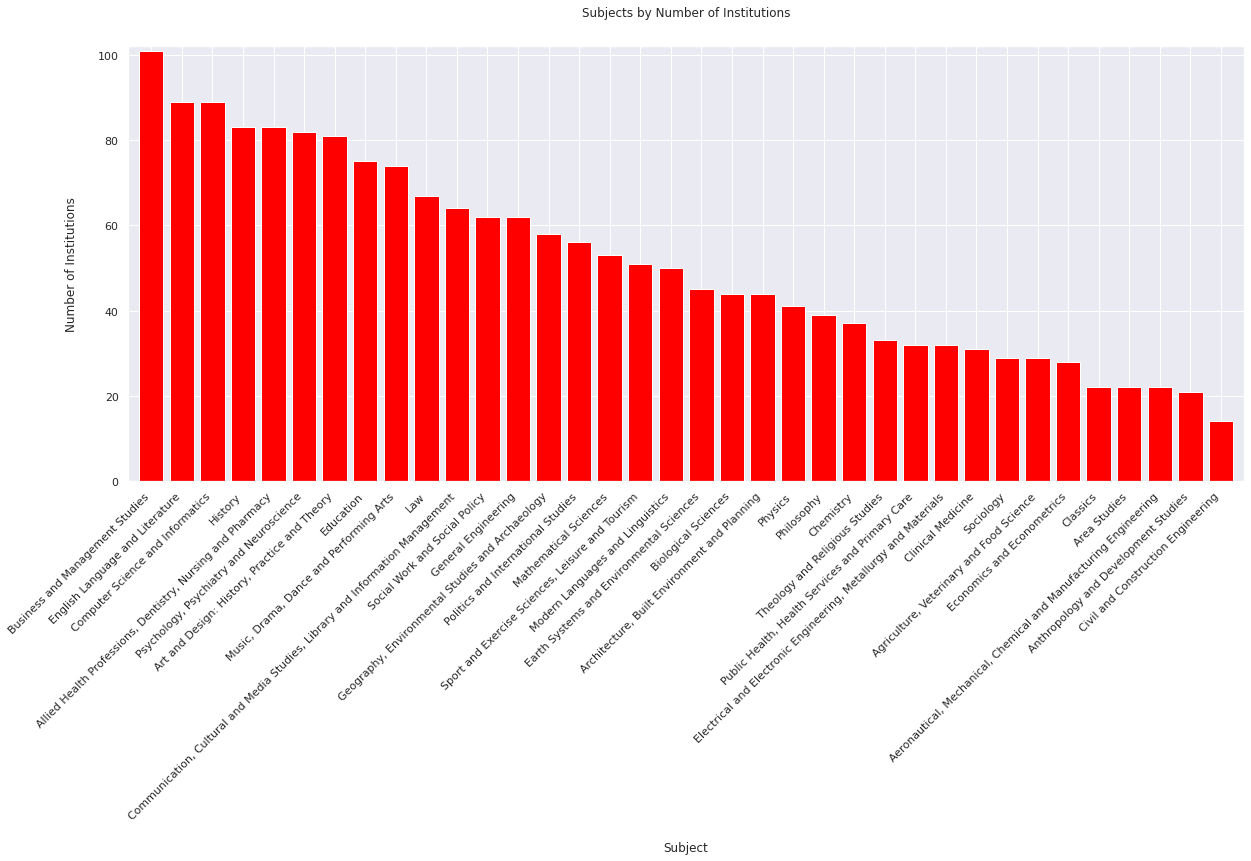

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Unit_of_Assessment_Name"].astype(str), height=result["Number_of_Institutions"], color='red')
plt.title("Subjects by Number of Institutions", pad = 30)
plt.xlabel("Subject", labelpad=20)
plt.ylabel("Number of Institutions", labelpad=20)
_ = plt.xticks(rotation = 45, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

###Which universities perform the best in the assessment?

Based on the data available, there are several ways we could try to establish which university performed the best across the assessment.

Each university gets an overall star rating for each subject it is assessed on. We can see which universities had the highest average percent 4* evaluations.

London Business School and Courtauld Institute of Art performed the best against this measure. But by including the total number of subjects they were assessed against, we see that both of these institutes are specialised in one subject area. It seems understandable that specialist institutions would perform better than those offering a large range of courses. However, the two worst performing institutions are also specialised in one subject each. 

In [ ]:
result = pd.read_sql("""WITH Four_Star_Percentages AS (SELECT DISTINCT Institution_Name, 
                                                      Unit_of_Assessment_Name,
                                                      Star_Rating,
                                                      Percentage
                                              FROM REF_Results
                                              WHERE Profile = "Overall" AND Star_Rating = "4*")
                                              
               SELECT Institution_Name,
                      COUNT(Unit_of_Assessment_Name),
                      CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) AS Average_4_Star_Percentage
               FROM Four_Star_Percentages
               GROUP BY Institution_Name
               ORDER BY CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) DESC
               LIMIT 20;""", database)

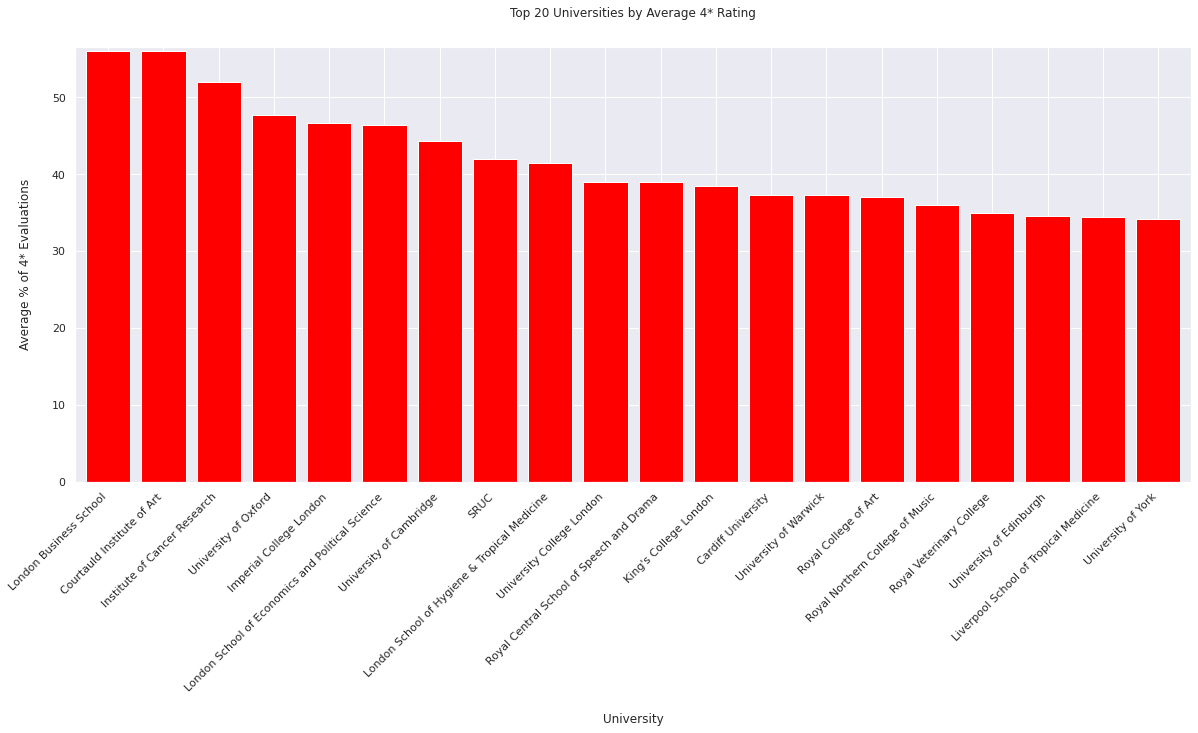

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Institution_Name"].astype(str), height=result["Average_4_Star_Percentage"], color='red')
plt.title("Top 20 Universities by Average 4* Rating", pad = 30)
plt.xlabel("University", labelpad=20)
plt.ylabel("Average % of 4* Evaluations", labelpad=20)
_ = plt.xticks(rotation = 45, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

What about the institutions which were the weakest performers in this assessment?

The unclassified rating is the lowest possible rating in the assessment. How often did institutions receive this rating?

In [ ]:
result = pd.read_sql("""WITH Unclassified_Percentages AS (SELECT DISTINCT Institution_Name, 
                                                      Unit_of_Assessment_Name,
                                                      Star_Rating,
                                                      Percentage
                                              FROM REF_Results
                                              WHERE Profile = "Overall" AND Star_Rating = "unclassified")
                                              
               SELECT Institution_Name,
                      COUNT(Unit_of_Assessment_Name),
                      CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) AS Average_Unclassified_Percentage
               FROM Unclassified_Percentages
               GROUP BY Institution_Name
               ORDER BY CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) DESC
               LIMIT 20;""", database)

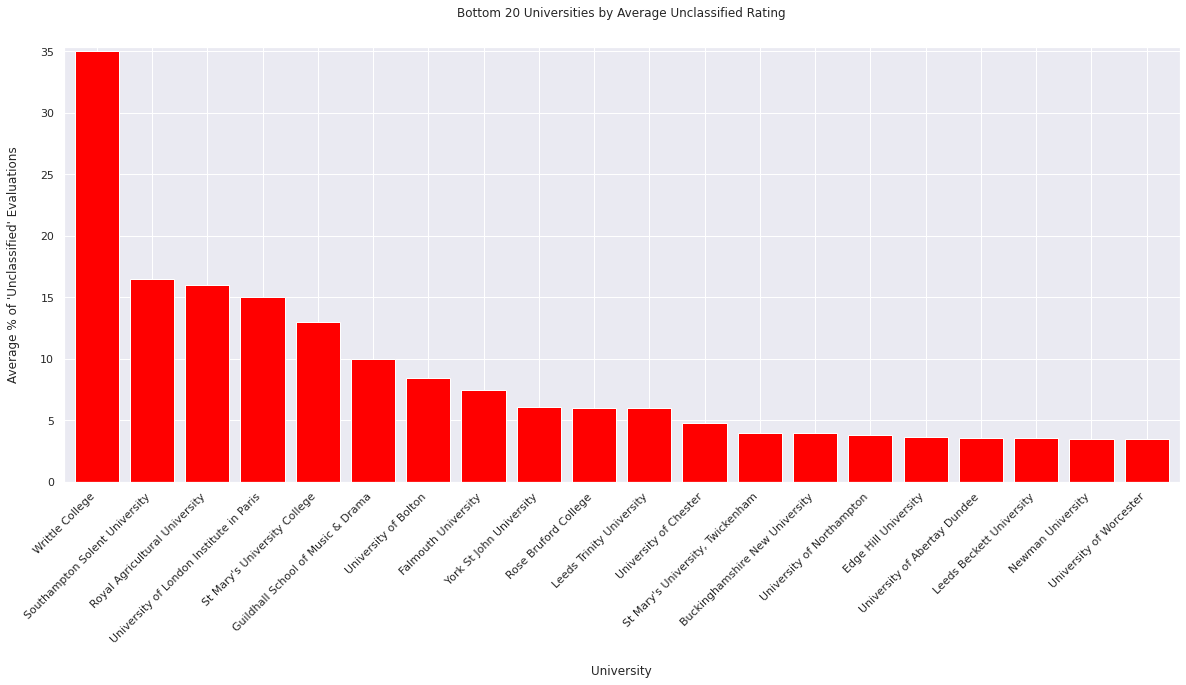

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Institution_Name"].astype(str), height=result["Average_Unclassified_Percentage"], color='red')
plt.title("Bottom 20 Universities by Average Unclassified Rating", pad = 30)
plt.xlabel("University", labelpad=20)
plt.ylabel("Average % of 'Unclassified' Evaluations", labelpad=20)
_ = plt.xticks(rotation = 45, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

## Which universities have the largest number of staff?

The REF results show how many full-time equivalent (FTE) staff members were submitted for the assessment. Which universities have submitted the highest staff numbers for assessment?

In [ ]:
result = pd.read_sql("""SELECT DISTINCT Institution_Name,
                                SUM(FTE_Category_A_staff_submitted) AS Number_of_Staff_FTE
               FROM REF_Results
               WHERE Profile = "Overall" AND Star_Rating = "4*"
               GROUP BY Institution_Name
               ORDER BY SUM(FTE_Category_A_staff_submitted) DESC
               LIMIT 20;""", database)

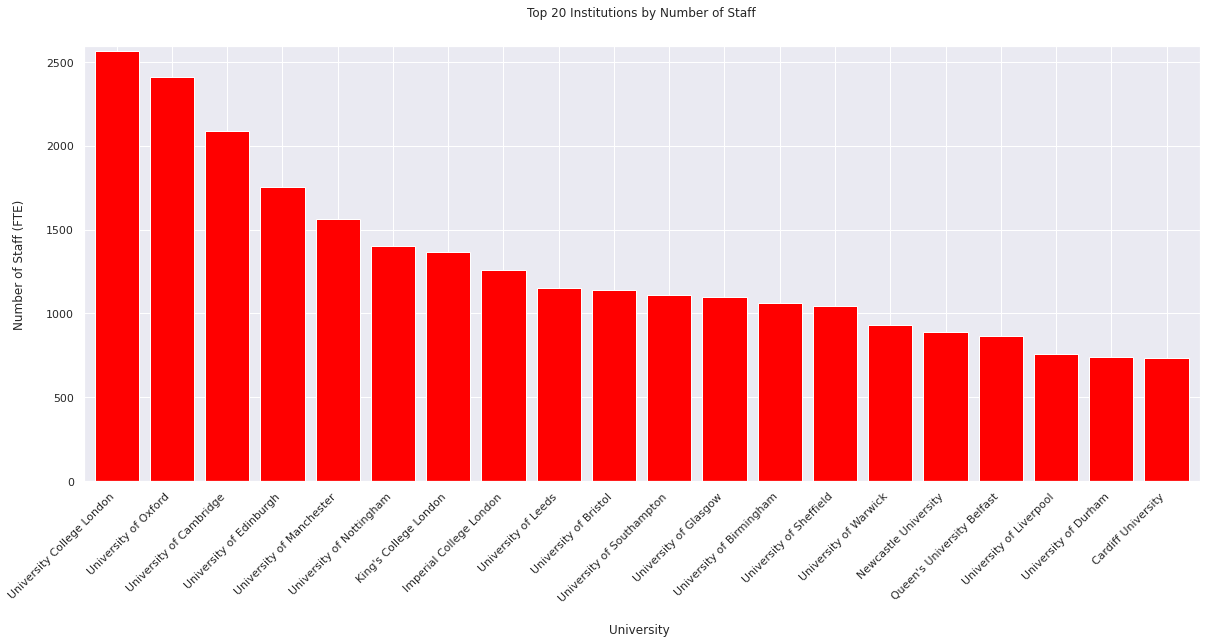

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Institution_Name"].astype(str), height=result["Number_of_Staff_FTE"], color='red')
plt.title("Top 20 Institutions by Number of Staff", pad = 30)
plt.xlabel("University ", labelpad=20)
plt.ylabel("Number of Staff (FTE)", labelpad=20)
_ = plt.xticks(rotation = 45, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

## And the smallest number of staff?

In [ ]:
result = pd.read_sql("""SELECT DISTINCT Institution_Name,
                                SUM(FTE_Category_A_staff_submitted) AS Number_of_Staff_FTE
               FROM REF_Results
               WHERE Profile = "Overall" AND Star_Rating = "4*"
               GROUP BY Institution_Name
               ORDER BY SUM(FTE_Category_A_staff_submitted) DESC
               LIMIT 20;""", database)

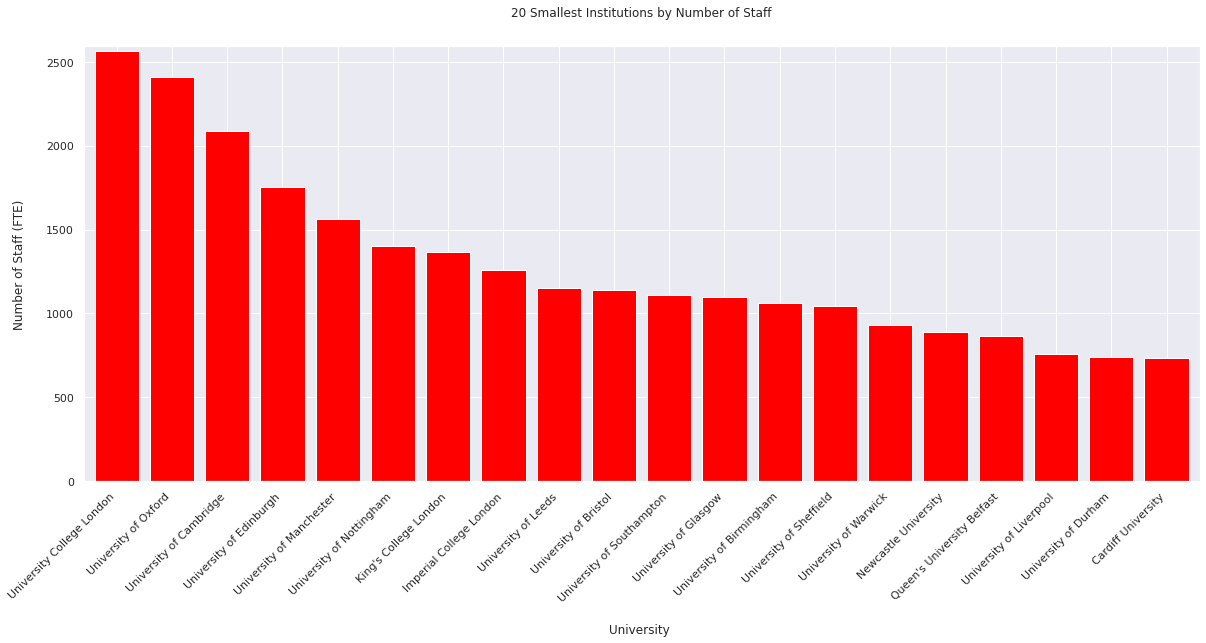

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(x=result["Institution_Name"].astype(str), height=result["Number_of_Staff_FTE"], color='red')
plt.title("20 Smallest Institutions by Number of Staff", pad = 30)
plt.xlabel("University ", labelpad=20)
plt.ylabel("Number of Staff (FTE)", labelpad=20)
_ = plt.xticks(rotation = 45, ha = "right")
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

## Which universities are the most collaborative?

Institutions were able to prepare joint submissions with another institution and submit this to the assessment.

Which universities submitted the most joint submissions?

In [ ]:
pd.read_sql("""SELECT * FROM REF_Results
                        WHERE 'Joint submission' LIKE "%joint%";""", database)

## How to find the best university for you

If you're trying to decide on a univeristy and course, you can tailor this search to see which universities performed the best in the in the subject you're interested in.

As a reminder, these are the subjects covered by the assessment. You can amend the WHERE clause in the next code block to focus your search.

In [ ]:
pd.read_sql("""SELECT DISTINCT Unit_of_Assessment_Name
               FROM REF_Results
               ORDER BY Unit_of_Assessment_Name ASC;""", database)

In [ ]:
pd.read_sql("""SELECT Institution_Name,
                      Unit_of_Assessment_Name,
                      CAST(Percentage AS INTEGER) AS 'Percentage Overall 4* Ratings'
                FROM REF_Results
                WHERE Star_Rating = "4*" AND Profile = "Overall" AND Unit_of_Assessment_Name = "Modern Languages and Linguistics" --change the last part depending on the subject of interest
                ORDER BY CAST(Percentage AS INTEGER) DESC
                LIMIT 10;""", database)